## Visually Simialr Images

This notebook will use an example dataset called Caltech-101, which contains roughly 9000 images in 101 categories.I have created one more folder 'shoes' and downloaded random shoe images from google.Download the Caltech-101 dataset using the below link.

wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz


In [4]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Lets import keras pre-trained neural network model VGG16.we can use any of the [pre-trained](https://keras.io/applications/) models.VGG16 model, with weights pre-trained on ImageNet.The default input size for this model is 224x224.

In [5]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

-include_top: whether to include the 3 fully-connected layers at the top of the network.
-weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet).
-input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
-input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
-pooling: Optional pooling mode for feature extraction when include_top is False.
-None means that the output of the model will be the 4D tensor output of the last convolutional layer.
-'avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the -output of the model will be a 2D tensor.
-'max' means that global max pooling will be applied.
-classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no  weights argument is specified.
The output is A Keras Model instance.

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
def load_image(path):
    img = image.load_img(path,target_size=model.input_shape[1:3])
    x= image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x= preprocess_input(x)
    return img,x

Lets check the data vector of an image

shape of x:  (1, 224, 224, 3)
data type: float32


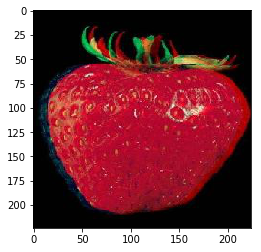

In [8]:
img,x = load_image("101_ObjectCategories/strawberry/image_0007.jpg")
print("shape of x: ", x.shape)
print("data type:",x.dtype)
plt.imshow(img)

The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if `x` has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward `x` through `model` and then use the built-in `decode_predictions` to look up the class names.

In [9]:
predictions = model.predict(x)
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred,prob))

predicted strawberry with probability 0.616
predicted orange with probability 0.073
predicted lemon with probability 0.046
predicted matchstick with probability 0.034
predicted candle with probability 0.027


### Feature extraction

What we have in the `model` variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for another task.

What we do is we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called `feat_extractor` is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. It looks like a copy, but internally, all Keras is doing is making a pointer to each of these layers and not actually copying anything. Thus, the output "prediction" from `feat_extractor` will just be the layer `fc2` from `model`.

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [10]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
img ,x = load_image("101_ObjectCategories/pizza/image_0007.jpg")
feat = feat_extractor.predict(x)

we will open a folder of images for analysis. First, the next cell will just recursively crawl the folder specified by `image_path` looking for images of the extensions inside of `image_extensions` and then limiting them to a random subset of maximum `max_num_images` images. Change these variables if you wish to change the target images.

In [12]:
images_path = '101_ObjectCategories'
image_extensions = ['.jpg','.png','.jpeg']
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]

In [13]:
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]
print("keeping %d images to analyze" % len(images))    

keeping 9144 images to analyze


In the next cell, we will begin a loop which will open each image, extract its feature vector, and append it to a list called `features` which will contain our activations for each image. This process may take a long time depending on your graphics card. Every 1000 images, you will receive a notification print-out.

In [14]:
import time
tic= time.clock()
features = []
for i ,image_path in enumerate(images):
    if i % 500 == 0 :
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img , x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)
print('finished extracting features for %d images' % len(images))    

analyzing image 0 / 9144. Time: 0.0001 seconds.
analyzing image 500 / 9144. Time: 875.2968 seconds.
analyzing image 1000 / 9144. Time: 841.4610 seconds.
analyzing image 1500 / 9144. Time: 851.1377 seconds.
analyzing image 2000 / 9144. Time: 856.5330 seconds.
analyzing image 2500 / 9144. Time: 838.5567 seconds.
analyzing image 3000 / 9144. Time: 842.6394 seconds.
analyzing image 3500 / 9144. Time: 846.2818 seconds.
analyzing image 4000 / 9144. Time: 864.0823 seconds.
analyzing image 4500 / 9144. Time: 847.0241 seconds.
analyzing image 5000 / 9144. Time: 839.2101 seconds.
analyzing image 5500 / 9144. Time: 842.3889 seconds.
analyzing image 6000 / 9144. Time: 854.1730 seconds.
analyzing image 6500 / 9144. Time: 838.4639 seconds.
analyzing image 7000 / 9144. Time: 817.4774 seconds.
analyzing image 7500 / 9144. Time: 816.3598 seconds.
analyzing image 8000 / 9144. Time: 836.4537 seconds.
analyzing image 8500 / 9144. Time: 828.4799 seconds.
analyzing image 9000 / 9144. Time: 849.8081 seconds.

Next step is to do a [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimensionality of our feature vectors down to 300. We apply PCA for two reasons: 1) the 4096-bit feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 2) Operating over 4096 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation. PCA allows us to do this by reducing the dimensionality down of the feature vectors from 4096 to much less, but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

The next cell will instantiate a `PCA` object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

In [15]:
from sklearn.decomposition import PCA
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)


PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The `pca` object stores the actual transformation matrix which was fit in the previous cell. We can now use it to transform any original feature vector (of length 4096) into a reduced 300-dimensional feature vector in the principal component space found by the PCA. 

So we take our original feature vectors, and transform them to the new space.

In [16]:
pca_features = pca.transform(features)

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.


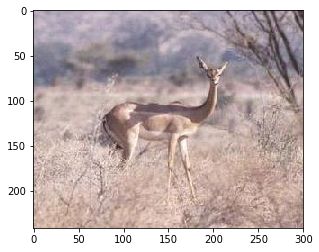

In [32]:
query_image_idx = int(len(images) * random.random())
img = image.load_img(images[query_image_idx])
plt.imshow(img)

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dissimilarity metric we use is [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). 

In [33]:
from scipy.spatial import distance
similar_idx = [ distance.cosine(pca_features[query_image_idx],feat) for feat in pca_features]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [34]:
idx_closest = sorted(range(len(similar_idx)), key= lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

In [35]:
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height),100))
    thumbs.append(img)

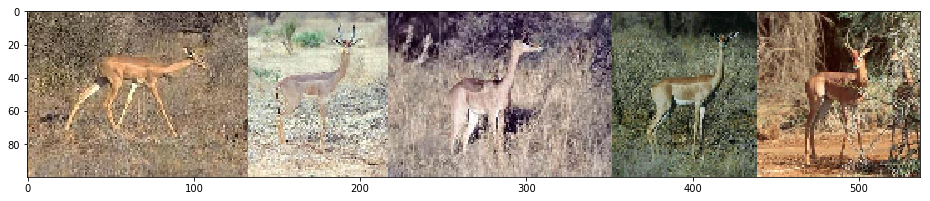

In [36]:
concat_image = np.concatenate([np.asarray(t) for t in thumbs],axis =1)
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [37]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [distance.cosine(pca_features[query_image_idx],feat) for feat in pca_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img= image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis= 1)
    return concat_image
        

Text(0.5,1,'result images')

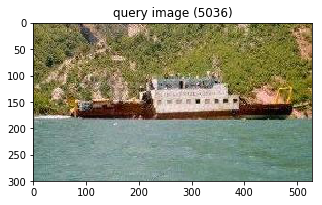

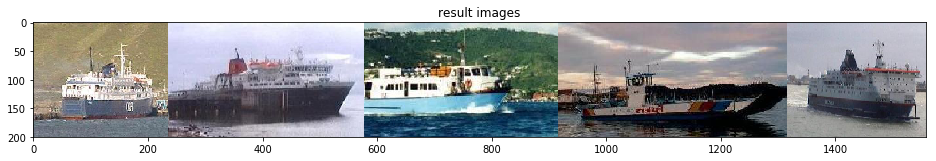

In [39]:
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx],300)
results_image = get_concatenated_images(idx_closest, 200)

plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

## Importing new images

I have imported an shoe image.Lets find similar image.

Text(0.5,1,'result images')

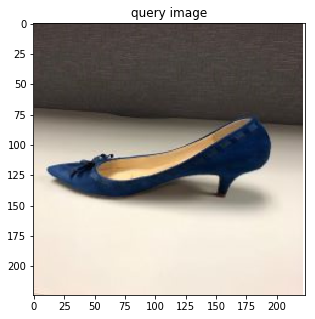

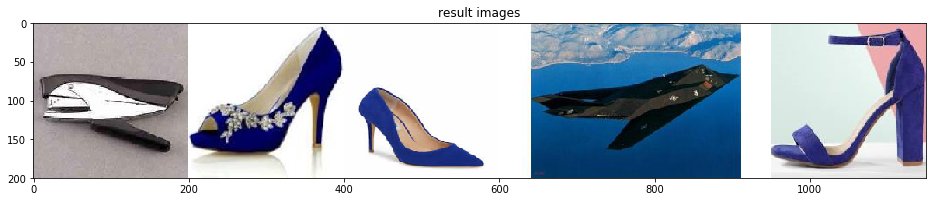

In [24]:
new_image ,x = load_image("shoe.png")
new_features = feat_extractor.predict(x)
new_pca_features = pca.transform(new_features)[0]
distances = [distance.cosine(new_pca_features, feat) for feat in pca_features]
idx_closest = sorted(range(len(distances)), key = lambda k: distances[k])[0:5]
results_image = get_concatenated_images(idx_closest,200)

plt.figure(figsize  =(5,5))
plt.imshow(new_image)
plt.title("query image")

plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")


This model performs better with large set of images that are trained.Just a recap of what we have done.
Prepare our image database.
Download the trained VGG model, and remove its last layers.
Convert our image database into feature vectors using our dissected VGG model. If the output layer of the dissected model are convolutional filters then flatten the filters and append them make a single vector.
Compute similarities between our image feature vectors using an inner-product such as cosine similarity or euclidean distance
For each image, select the images with the top-k similarity scores to build the recommendation.